<a href="https://colab.research.google.com/github/mugobrian201/portfolio/blob/main/Earthquake_Damage_in_Nepal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project will focus on analyzing data from the 2015 Nepal earthquake. The aim is to develop a predictive model to determine if a building will likely suffer severe damage in a similar earthquake based on its characteristics. I am going to use two Machine Learning Models, that is, Logistic Regression and Decision Tree Classifier. The project involves an end-to-end data science approach, starting with exploring my dataset, cleaning it and creating a wrangle function.

This project is significant in the real world. By forecasting damage levels based on building features, it enhances preparedness through faster resource allocation and targeted rescue operations, potentially saving lives in remote terrains. It is useful in identifying vulnerable features in various buildings thus help in mitigating risks. These machine learning models will help reduce earthquake mortality rates.

# **Part one : Predicting Damage with Logistic Regression**

In this first part of my project, I will focus on preparing my csv data for building a classification model.

I want to upload my csv file that I accessed from Kaggle.

I also want to successfully import the necessary libraries.

I want to prepare my data for binary classification (houses severely damaged vs houses not severely damaged). Then I create a Logistic Regression Model to predict severe damage. I will also explain Model predictions using odds ratio.

I will also use the usual Machine Learning Workflow. In the import phase, I will prepare my data to work with a binary target. In the exploration phase, I will examine class balance and perform a randomized train-test split. In setting my baseline, I will use accuracy scores, then proceed with Logistic Regression during Iteration then evaluate my model using accuracy scores.

Uploading my csv File

In [1]:
# Uploading my nepal.sqlite file to Colab
from google.colab import files
import pandas as pd

# Upload my csv file
uploaded = files.upload()

Saving nepal.sqlite.csv to nepal.sqlite.csv


Importing the necessary libraries

In [ ]:
!pip install category_encoders

In [3]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree


warnings.simplefilter(action="ignore", category=FutureWarning)

# **WRANGLE FUNCTION**

In [4]:
def wrangle(filepath):
  df = pd.read_csv(filepath)
  #Identify leaky columns
  drop_cols = [col for col in df.columns if "post_eq" in col]
  #Drop 'post_eq' features
  df.drop(columns=drop_cols, inplace=True)
  #Set 'building_id' as my index
  df.set_index("building_id", inplace=True)
  #Drop NaN Values
  df.dropna(inplace=True)
  #Accessing a number in a string and converting it from object to integer then reassign it
  df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
  #Binary Encoding
  #Grades 1-3(0) and grades 4-5(1)
  df["severe_damage"] = (df["damage_grade"] > 3).astype(int)
  #Drop leaky feature, highly correlated feature, drop other irrelevant columns
  df.drop(columns=["damage_grade","count_floors_pre_eq","district_id", "vdcmun_id", "ward_id", "technical_solution_proposed"], inplace=True)


  return df

In [5]:
df = wrangle("nepal.sqlite.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 762094 entries, 120101000011 to 366709001281
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   age_building            762094 non-null  int64 
 1   plinth_area_sq_ft       762094 non-null  int64 
 2   height_ft_pre_eq        762094 non-null  int64 
 3   land_surface_condition  762094 non-null  object
 4   foundation_type         762094 non-null  object
 5   roof_type               762094 non-null  object
 6   ground_floor_type       762094 non-null  object
 7   other_floor_type        762094 non-null  object
 8   position                762094 non-null  object
 9   plan_configuration      762094 non-null  object
 10  superstructure          762094 non-null  object
 11  severe_damage           762094 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 75.6+ MB


# **Drop Leaky Features**

I need to examine the features in my csv file to see which columns need to be kept and which need to be dropped.

My aim is to predict whether a building will suffer severe damage or not in an earthquake(before the earthquake happens).

Such features would give the model information it would not have in the real world. During training, the model should not have any post-earhquake information.

I will also create a wrangle function that will contain the changes I will make to my dataset.

# **Binary Classification Feature**

I am dealing with a binary classification problem. I need to categorize the buildings into two groups; that is, severely damaged and not serverely damaged. I will need to explore the 'damage_grade' column to see what is present.

The column is of data type object, and each building consists of a grade followed by a number. There are 5 different levels of damage, from least to most severely damaged. I will pull 1,2,3,4,5 without 'Grade' ie. Access a string and convert it from object to integer and reassign it.

I want to create two classes: the most severely damaged buildings (damage grade 4 or 5) as the positive class labeled as one, and the rest as the negative class labeled as zero, which will be added to my wrangle function.

I will then drop 'damage_grade' column to avoid leakage.

In [6]:
print(df["severe_damage"].value_counts())

severe_damage
1    459610
0    302484
Name: count, dtype: int64


# **EXPLORE**

For a Logistic Regression, the issue of Multicollinearity also needs to be considered. This will be through a Heatmap and Correlation Matrix.

I will consider all features that involve numbers and drop the target variable.

## **Correlation Heatmap**

<Axes: >

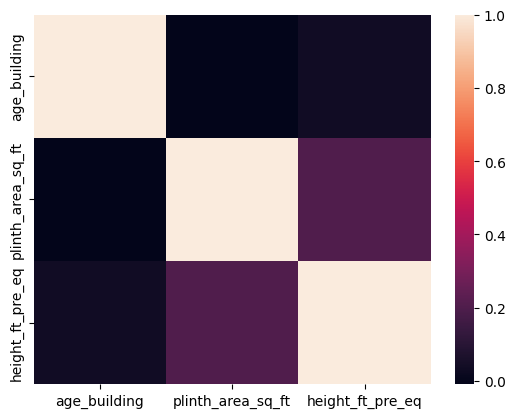

In [7]:
#Correlation Matrix
correlation = df.select_dtypes("number").drop(columns="severe_damage").corr()
#Plot correlation Matrix
sns.heatmap(correlation)

From the above visualization, the dark colors represent little to no correlation while the brighter colors indicate a stronger positive correlation. I need to focus on the brighter colors.

It is clear that there is a strong correlation between the number of floors in the building and the height of the building. One of these two columns need to be dropped.

I will look at the correlation between each of these columns and the target variable column and the feature with a larger positive correlation will be dropped.

In [ ]:
df['severe_damage'].corr(df['count_floors_pre_eq'])

In [ ]:
df['severe_damage'].corr(df['height_ft_pre_eq'])

The number of floors have a higher correlation with the target column hence needs to be dropped.

## **Seaborn Boxplot**

I want to check if there is a relationship between my target column(which is a categorical variable) and the other features where most of them are continous variable. I will be able to achieve this using a seaborn boxplot

Text(0.5, 1.0, 'Distribution of Height by class')

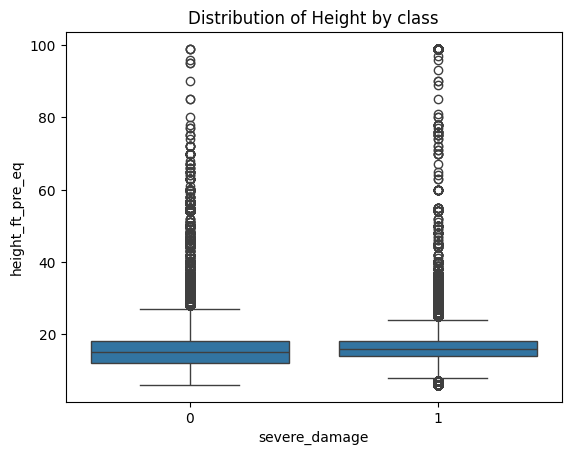

In [9]:
sns.boxplot(x="severe_damage", y="height_ft_pre_eq", data=df)
plt.title("Distribution of Height by class")

From the visualization, it is clear that most buildings that did not suffer severe damage are below 20 feet. However, there is no significant difference between the two classes. If there would be a significant difference between the two, it would indicate a stronger relationship between the two.

I want to look at the proportion between less severely damaged buildings and severely damaged buildings, through code and also visualization.

# **Class Balance Bar Chart**

<Axes: title={'center': 'Class Balance Bar Chart'}, xlabel='Class', ylabel='Frequency'>

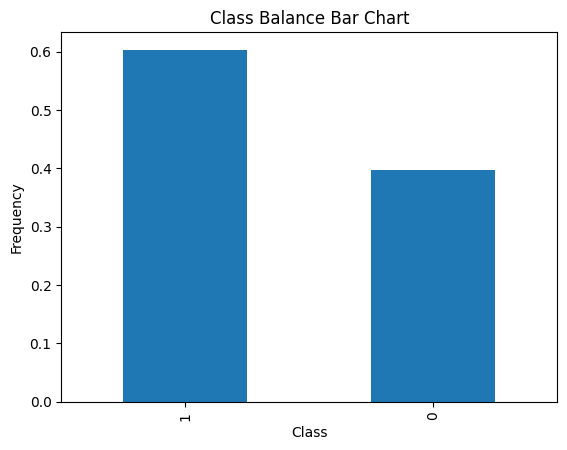

In [10]:
df["severe_damage"].value_counts(normalize=True).plot(kind="bar", xlabel="Class", ylabel="Frequency", title="Class Balance Bar Chart")

It is clear that 60% of the buildings are severely damaged while 40% of the buildings are less severely damaged. This shows a good balance between the classes(not an imbalanced dataset)

I want to also create two variables that will store the proportion of each of the classes.



In [11]:
majority_class_prop, minority_class_prop = df["severe_damage"].value_counts(normalize=True)
print(majority_class_prop, minority_class_prop)

0.6030883329353072 0.39691166706469283


# **Pivot Table**

A tool in Data Science used to summarize and reorganize data from a long and narrow format to a short and wide format.

I want to look at the relationship between the foundation type of a building and whether that building suffered severe damage.

The mean function will be used to calculate the mean of each group's severe damage proportion.

In [12]:
foundation_pivot = pd.pivot_table(
    df, index = "foundation_type", values = "severe_damage", aggfunc=np.mean).sort_values(by="severe_damage")
foundation_pivot

,severe_damage
foundation_type,
RC,0.038263
Bamboo/Timber,0.237855
Cement-Stone/Brick,0.296904
Other,0.510545
Mud mortar-Stone/Brick,0.685115


The output shows that there is indeed a relationship between the foundation type of a building and whether it suffered severe damage.

Buildings with Reinforced Concrete(RC) are less likely to suffere severe damage as compare to Bamboo(23.8%), Cement-Stone(29.7%), Other(51%) and Mud mortar-Stone(68.5%).

**Bar Chart: Damage by Foundation**

I want to create a visualization to compare proportions of 'foundation_pivot' to those of majority(1) and minority classes(0), then I add vertical lines at the values for majority and minority propotions.

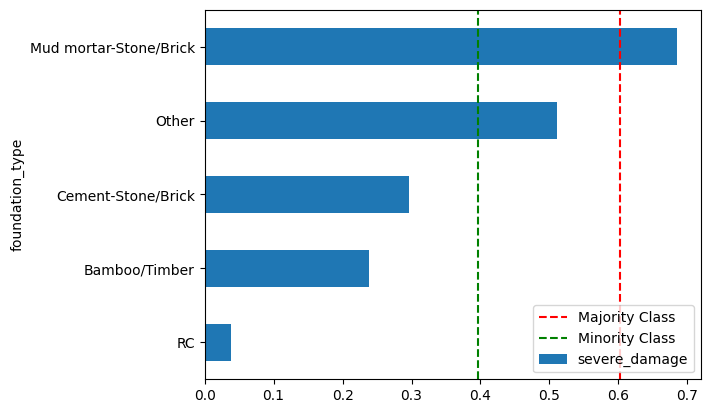

In [13]:
foundation_pivot.plot(kind="barh", legend=None)
plt.axvline(majority_class_prop, linestyle="--", color="red", label="Majority Class") #axv=axes vertical line
plt.axvline(minority_class_prop, linestyle="--", color="green", label="Minority Class")
plt.legend(loc="lower right")

From the visualization, it is seen that buildings with Mud-mortar stone foundation type had a significantly higher rate of severe damage, while RC buildings had a lower proportion of significantly damaged buildings.

## **Cardinality Features**

I also need to check for high and low cardinality features no know which are less significant for my model and need to be dropped.

In [14]:
df.select_dtypes("object").nunique()

,0
land_surface_condition,3
foundation_type,5
roof_type,3
ground_floor_type,5
other_floor_type,4
position,4
plan_configuration,10
superstructure,11


There no high or low cardinality features.

# **Split**

In [15]:
#Create Target Vector(y) and Feature Matrices(X)
target = "severe_damage"
X = df.drop(columns = target)
y = df[target]


Randomized Train-Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X train:", X_train.shape)
print("X test:", X_test.shape)
print("y train:", y_train.shape)
print("y test:", y_test.shape)

X train: (609675, 11)
X test: (152419, 11)
y train: (609675,)
y test: (152419,)


I have successfully imported, cleaned and explored my data. I have also split my data into feature matrix, target vector, training and test data. Now I want to build a Baseline for my classification problem.

To establish a good baseline, I need to build a naive model that always predicts my majority class. It will help compare the perfomance of my regression model.

# **Build Model**

# **Baseline**

**Baseline Accuracy Score**

Accuracy Score will be my performance metric which is equal to the Number of correct predictions(true +ves and true -ves) / Total no. of predictions(true +ves, true -ves, false +ves, false -ves)

An accuracy score of 0 is not good, of 1 is perfect.

My baseline accuracy score needs to be close to the proportion of Majority Class.

In [17]:
acc_baseline = y_train.value_counts(normalize=True).max()
acc_baseline

0.6035281092385287

For my model to work, it needs to be more than 0.6035, that is, it needs to be closer to 1.
My goal is to create a model that beats the baseline accuracy score.

# **Iterate**

A Logistic Regression Model is a classifier version of Linear Regression.

It will predict probability values that will be used to assign class labels and works by taking the output of a linear regression model and feeding it into a sigmoid or logistic function.

That is;
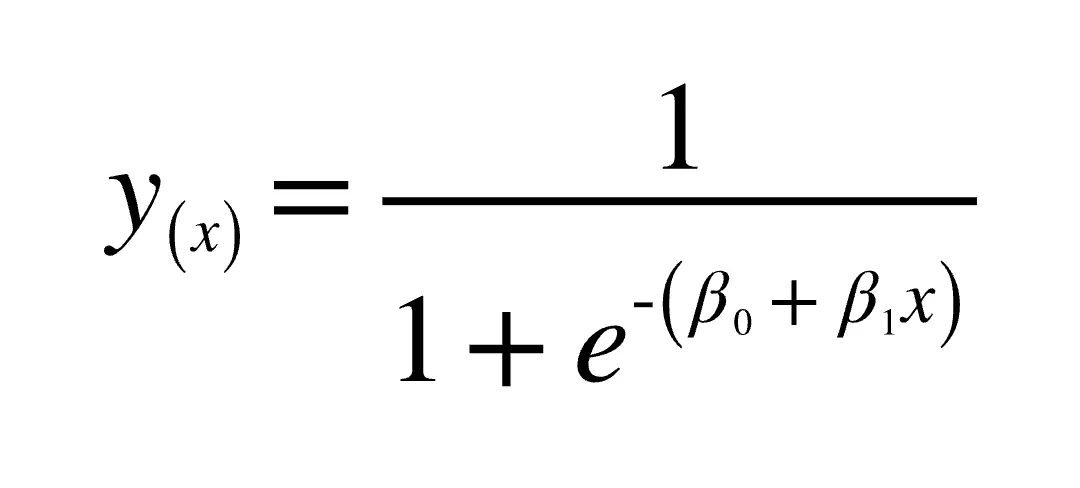

For values between 0 and 1, a cutoff line at 0.5 is established. Any value below the cutoff line is predicted as zero, and anything above is predicted as one.



In [18]:
#Build Model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter = 1000)
)
model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

Sometimes logistic regression models encounter a convergence warning, indicating that they didn’t have enough time to estimate all the coefficients accurately. To address this, I can increase the max_iter (maximum number of iterations) parameter to a higher value, like a thousand, to avoid the warning.

## **Evaluate**

After successfully training my model, I want to assess the model's perfomance. There are two methods for calculating accuracy scores in scikit-learn.

The first one is going to involve using the accuracy function to predict the true labels of my training data.

The second function will use model.score() where I will use X_test and y_test.

In [19]:
acc_train = accuracy_score(y_train, model.predict(X_train))
print("Training Accuracy:", round(acc_train, 2))
acc_test = model.score(X_test, y_test)
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.73
Test Accuracy: 0.73


Both my training and accuracy scores have beat the baseline. This is excellent news as I can now proceed to Communicating my results.

# **Communicate Results**

Logistic Regression ends up with final predictions of either 0(less severely damaged) or 1(severely damaged). However, below these predictions, there are probability estimates represented by floating numbers between 0 and 1. I want to examine both the predictions and probabilities of the first 5 predictions.

In [20]:
#Predictions
model.predict(X_train)[:5]

array([1, 1, 1, 0, 1])

The output indicates that the first three have been predicted to be severely damaged wheres the fourth one is predicted to be less severely damaged while the fifth one is severely damaged.

In [21]:
#Probabilities of the first 5 predictions
y_train_predict_proba = model.predict_proba(X_train)
y_train_predict_proba[:5]

array([[0.29502489, 0.70497511],
       [0.25510276, 0.74489724],
       [0.22656157, 0.77343843],
       [0.54263562, 0.45736438],
       [0.31236959, 0.68763041]])

The output returns a nested list with two columns.
(focusing on the first prediction), it indicates that the model predicted a 29% chance of the building to belong to the negative class(0) and a 70% chance of the building to belong to the positive class(1). It then concluded that the building is predicted to be severely damaged.

The next thing I need to do is extract feature names and importances from my model using odds ratio. I need to remember that I have a linear equation wrapped in a sigmoid function.

After this, I need to plot a Horizontal Bar Chart of my odds ratio and interprete my results from the visualization. I want to focus on the best 5 coefficients.

Also an odds ratio >1 means the feature increases the odds of the outcome

In [22]:
#Extract feature names and importances from my model
features = model.named_steps["onehotencoder"].get_feature_names_out()
print(features[:5])
importances = model.named_steps["logisticregression"].coef_[0]
print(importances[:5])

['age_building' 'plinth_area_sq_ft' 'height_ft_pre_eq'
 'land_surface_condition_Flat' 'land_surface_condition_Moderate slope']
[ 4.18090833e-04 -2.42382765e-04  2.11526704e-02 -2.33839167e-01
 -2.79045221e-01]


In [23]:
odds_ratio = pd.Series(np.exp(importances), index = features).sort_values()
odds_ratio.head()

,0
superstructure_has_superstructure_cement_mortar_brick,0.278323
foundation_type_RC,0.454396
superstructure_has_superstructure_rc_non_engineered,0.480985
superstructure_has_superstructure_rc_engineered,0.507927
roof_type_RCC/RB/RBC,0.532836


<Axes: xlabel='Odds Ratio'>

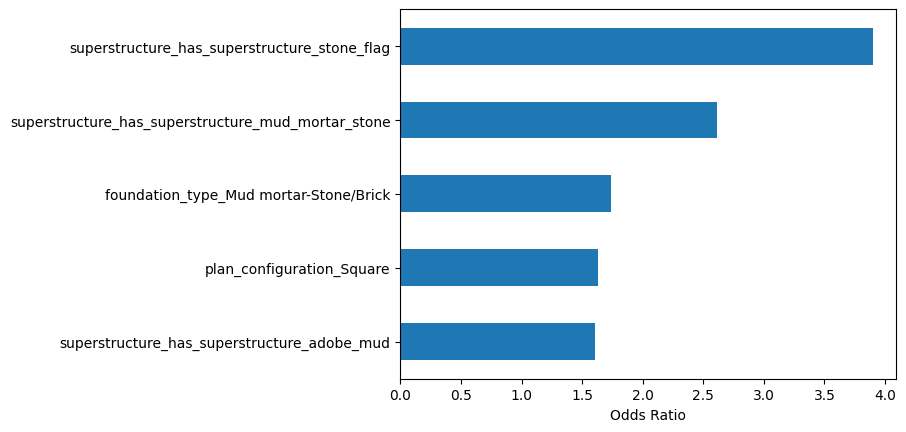

In [24]:
#Building features associated with an increase in severe damage
odds_ratio.tail().plot(kind="barh", xlabel="Odds Ratio")

The above Horizontal Bar chart indicates the top 5 features associated with an increased likelihood of severe damage. Any odds ratio over one indicates a likelihood of increased severe damage.

Example, a building that has a superstructure with stone flag has a 200% increased likelihood of severe damage.

<Axes: xlabel='Odds Ratio'>

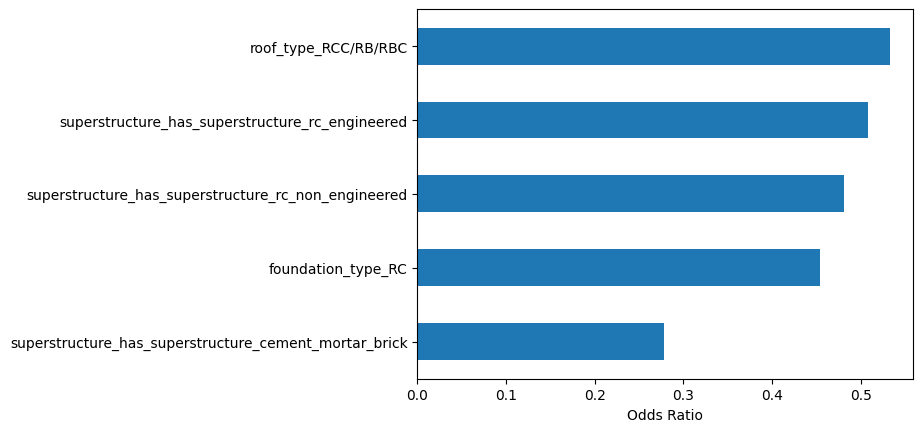

In [25]:
#Building features associated with a decrease in severe damage
odds_ratio.head().plot(kind="barh", xlabel="Odds Ratio")

The above Horizontal Bar chart indicates the top 5 features associated with a decreased likelihood of severe damage.

Example, a building with roof types Reinforced Cement Concrete(RCC), Reinforced Brick(RB), Reinforced Brick Concrete(RBC) are 50% less likely to suffer severe damage.

# **Conclusion**

I have worked with a classification problem, and created a Binary Target where class 0 represented buildings that were less severely damaged and class 1 represented buildings that were severely damaged.

In my data exploration, I focused on analysing class balance and proportion of positive and negative classes. I created a majority class and minority class for my proportions then proceeded to splitting using a randomized train-test split.

In Building my logistic regression model, I created my baseline using accuracy score then fit my model. I proceeded to comparing my accuracy scores using two methods, against the baseline.

Finally, I extracted my feature names and importances, plotted my odds ratio and interpreted my results showing the various types of buildings that were highly likely to suffer severe damage.

My next part will be predicting Damage using Decision Trees.

# **Part two : Predicting Damage with Decision Trees**

In this second part, I want to focus on creating a Decision Tree to help me predict severe damage in Nepal.

I will also tune in Hyperparameters for my model.

I will also explain model predictions using gini importances.

I will also use the usual Machine Learning workflow. Most parts will be similar to my part one. However, in splitting I will conduct a three way split, ie train, validation and test sets.

These are the three main part for my iteration phase; decision trees, ordinal encoding for categorical variables, and plotting a validation curve to help tune the hyperparameters for my decision tree model.

For evaluation, in the last part of the ML workflow, I will focus on Gini's importance

# **Split**

In [26]:
target_dt = "severe_damage"
X_dt = df.drop(columns = target_dt)
y_dt = df[target_dt]


I want to perform a randomized split in two steps, that is, a train-validation-test split.

I want to use the validation set for tuning my model with hyperparameters that will help make adjustments before training my model using the test set. I will be able to check the model's performance using the validation set. I will use X_train and y_train as opposed to X and y that I usually use for my train-test split.

In [27]:
#Perform train-test split for my DT Model
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt, y_dt, test_size=0.2, random_state=42)

In [28]:
#Perform train-validation split for my model
X_train_dt, X_val_dt, y_train_dt, y_val_dt = train_test_split(X_train_dt, y_train_dt, test_size=0.2, random_state=42)

My validation split will be 20% of my training set. My training set will now become 60%, my test set will remain 20% of my data.(the 20-20-60 split)

# **BUILD MODEL**

## **Baseline**

In [29]:
acc_baseline_dt = y_train_dt.value_counts(normalize=True).max()
print("Baseline:", round(acc_baseline_dt, 2))

Baseline: 0.6


For my model to work, it needs to beat this baseline score.

I want to iterate my model, that is, using a Decision Tree Classifier alongside an Ordinal Encoder.

The Decision Tree works by grouping all training observations into a single node. In this case, it contains two classes(severely damaged buildings and not severely damaged buildings). It will further separate the two classes in this root node. The main aim is to achieve purity and on the first division, it will not be able to achieve this purity. This purity means one node will contain specifically severely damaged buildings while the other node will explicitely contain not severely damaged buildings. There will be several divisions to be able to reach complete purity.

The number of divisions required to achieve purity is known as depth. The final set of nodes are referred to as terminal nodes.

The Decision Tree does this for all features(both numerical and categorical variables)

Unlike OneHotEncoder, ordinal encoder assigns unique integer numbers to each category in that categorical feature. An example is the foundation feature with Wood(1), Brick(2) and Reinforced Concrete(3).

Ordinal encoding works well with decision trees because the decision tree algorithm aims to divide nodes into subgroups to achieve maximum purity, and it doesn't rely on mathematical operations with categories.

## **Iterate**

In [30]:
model_dt = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(random_state=42)
)
model_dt.fit(X_train_dt, y_train_dt)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
has_superstructure_adobe_mud               3
has_superstructure_timber                  4
has_superstructure_stone_flag              5
has_superstructure_rc_non_engineered       6
has_superstructure_cement_mortar_stone     7
has_superstructure_mud_mortar_brick        8
has_superstructure_rc_engineered           9
has_superstructure_bamboo                 10
has_superstructure_other                  11
NaN                                       -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

## **Evaluate**

I want to see how my model performs with my training and validation data before seeing its performance with my test data.

In [31]:
acc_train_dt = accuracy_score(y_train_dt, model_dt.predict(X_train_dt))
print("Training Scores:", round(acc_train_dt,2))
acc_val_dt = model_dt.score(X_val_dt, y_val_dt)
print("Validation Score:", round(acc_val_dt,2))

Training Scores: 0.94
Validation Score: 0.65


The training score is nearly perfect even close to reaching 100% as opposed to my validation score that has beaten my baseline by only 5%. There is a big difference between the two scores.

This means my model is failing to generalize well and I need to do some hyperparameter tuning to address the issue.

Flexibility of the DTC leads to overfitting. The more the depth the more the flexibility and overfitting. If I control the tree depth, I will be able to make my model more or less flexible. I want to calculate the tree depth of my model.

In [32]:
#Get tree depth
tree_depth = model_dt["decisiontreeclassifier"].get_depth()
print("Tree Depth:", tree_depth)

Tree Depth: 59


## **Hyperparameter Tuning**

I want to determine the best depth for my model, since 59 is quite excessive.

I am going to create a range of values from 1 to 60 with steps of 2 for the max depth and test each of these possible values to see which is the best max depth.

Max Depth determines the maximum depth of a decision tree which in turn affects the model's accuracy and complexity.

In [33]:
depth_hyperparams = range(1, 60, 2)

I want to create a code that will initialize the training and validation scores of each of the range of values for my tree depth.
I will start by creating an empty list for each of my accuracy scores then create a for loop that will add each of the possible range of values for my max_depth, then build my test model and calculate each of the scores.

In [34]:
#Create empty lists for my accuracy scores
training_acc = []
validation_acc = []
#Create a for loop for my depths
for d in depth_hyperparams:
  #Build a model
  test_model = make_pipeline(
      OrdinalEncoder(),
      DecisionTreeClassifier(max_depth=d, random_state=42)
  )
  test_model.fit(X_train_dt, y_train_dt)
  #Append the values of training accuracy scores
  training_acc.append(test_model.score(X_train_dt, y_train_dt))
  #Append the values of validation accuracy scores
  validation_acc.append(test_model.score(X_val_dt, y_val_dt))
print("Training accuracy scores:", training_acc[:3])
print("Validation accuracy scores:", validation_acc[:3])

Training accuracy scores: [0.6774121458153934, 0.7228236355435272, 0.7271415098208062]
Validation accuracy scores: [0.6773608889982368, 0.7213269364825522, 0.7259523516627712]


# **Validation Curve**

Line for training accuracy scores and line for validation accuracy scores.

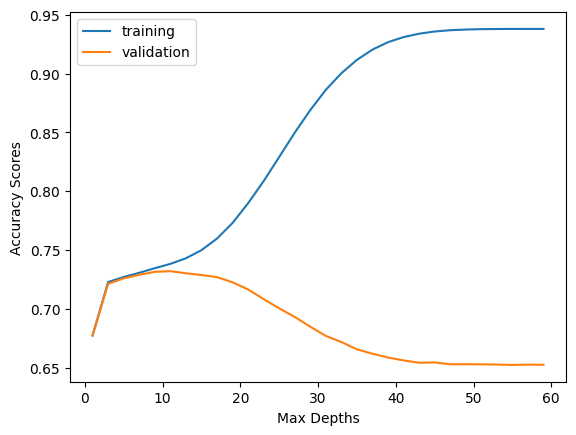

In [35]:
plt.plot(depth_hyperparams, training_acc, label = "training")
plt.plot(depth_hyperparams, validation_acc, label = "validation")
plt.xlabel("Max Depths")
plt.ylabel("Accuracy Scores")
plt.legend();

From the visualization;

For the training data, as the max depth increases I introduce more and more flexibility to the model and it is able to predict training data accurately.

For Validation data, as the max depth increases, the scores initially increase then tend to decrease later on.

I need to choose the max depth that leads to the best validation score. In this case, max_depth = 10 has the best validation accuracy score.

I need to rebuild and retrain my model with max_depth = 10.

In [36]:
model_dt = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=10, random_state=42)
)
model_dt.fit(X_train_dt, y_train_dt)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
has_superstructure_timber                  4
has_superstructure_stone_flag              5
has_superstructure_rc_non_engineered       6
has_superstructure_cement_mortar_stone     7
has_superstructure_mud_mortar_brick        8
has_superstructure_rc_engineered           9
has_superstructure_bamboo                 10
has_superstructure_other                  11
NaN                                       -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=10, random_state=42))])

In [37]:
acc_train_dt = accuracy_score(y_train_dt, model_dt.predict(X_train_dt))
print("Training Scores:", round(acc_train_dt,2))
acc_val_dt = model_dt.score(X_val_dt, y_val_dt)
print("Validation Score:", round(acc_val_dt,2))

Training Scores: 0.74
Validation Score: 0.73


After retraining, I have been able to solve the issue of overfitting with these new accuracy scores. This has been achieved by tuning hyperparameters.
It is time to see my model's performance with my text data(data the model has never seen)

In [38]:
test_acc = model_dt.score(X_test_dt, y_test_dt)
print("Test Accuracy Score:", round(test_acc ,2))

Test Accuracy Score: 0.73


The score hassuccessfully beat my baseline

# **Communicate Results**

I want to create a clear visualization of the Decision Tree Model I have built using the plot.tree() function. I need to pass in the decision tree and feature names in my dataset.
It will help me interprete the visualizations together as a group, as it will provide insights to the splits, impurity, total samples and sample proportions at each node in the decision tree.

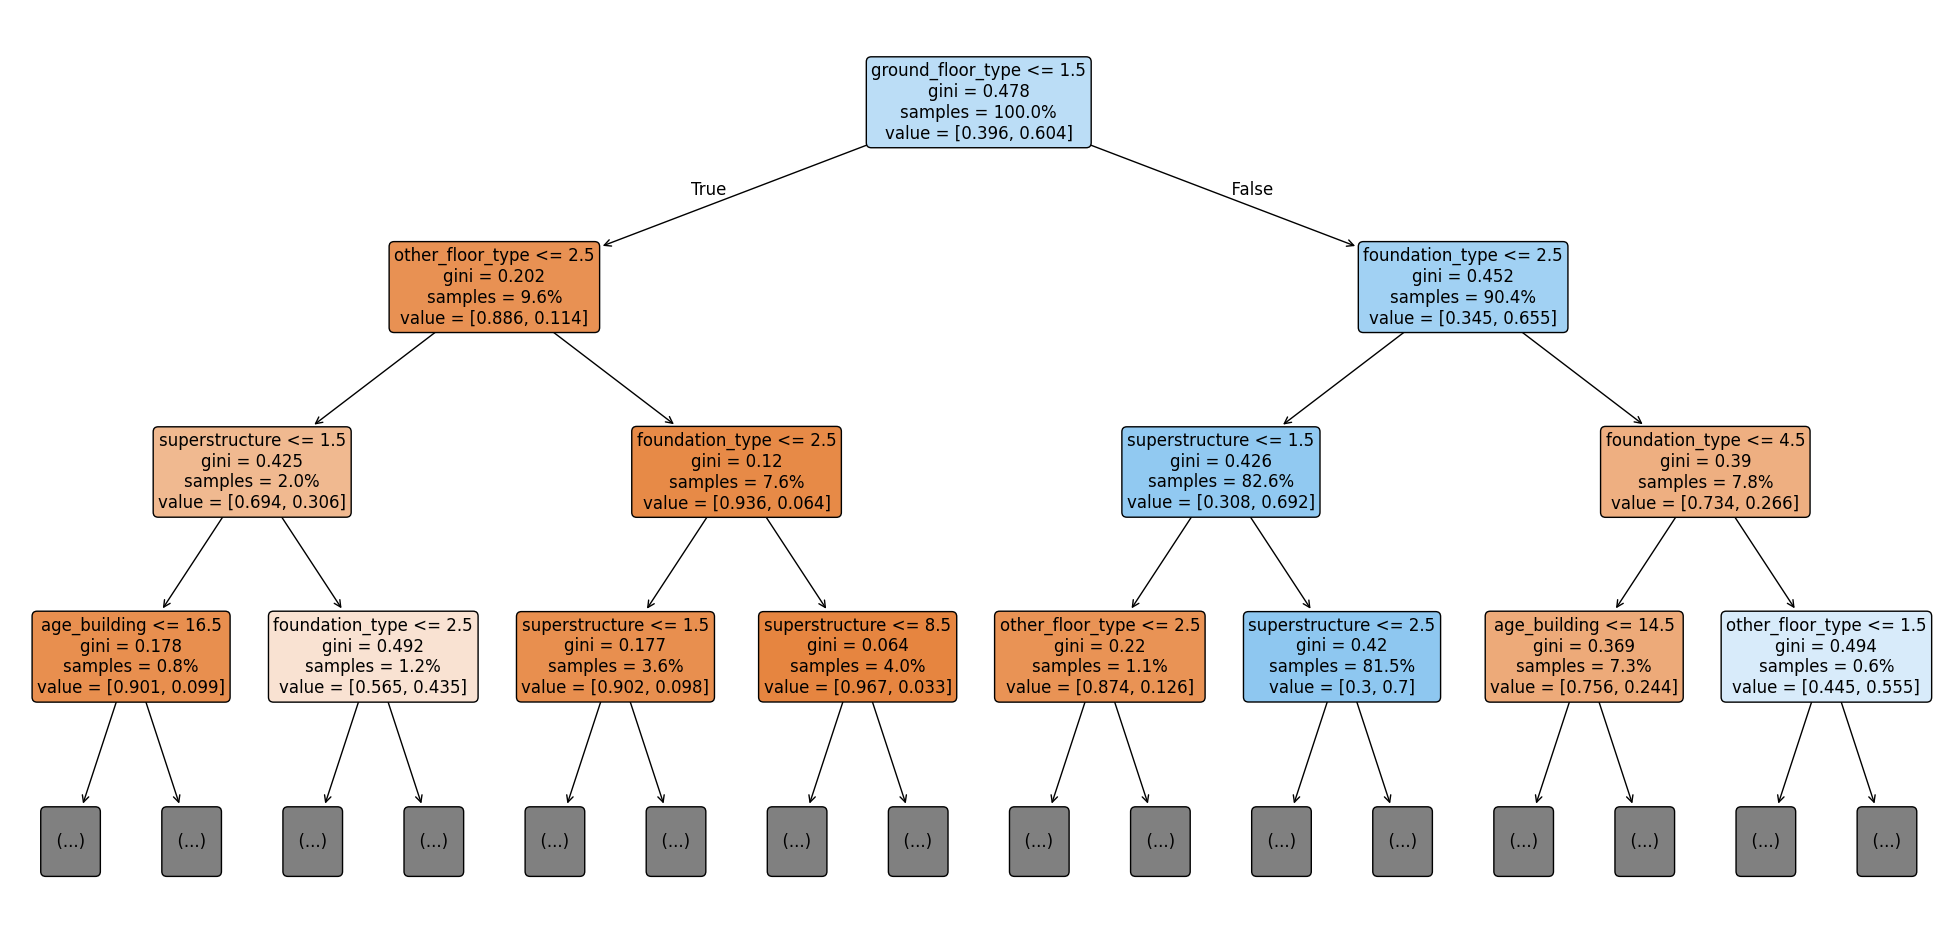

In [39]:
fig, ax = plt.subplots(figsize=(25,12))
#plot tree
plot_tree(
    decision_tree = model_dt.named_steps["decisiontreeclassifier"],
    #Extract names of feature columns in X_train
    feature_names = X_train_dt.columns.to_list(),
    filled = True, # color leaf with class
    rounded = True, #Round leaf edges
    proportion = True, #Display proportion of classes in leaf
    max_depth = 3, #Display the first three leaf nodes
    fontsize = 12, #Enlarge Font
    ax=ax,
    );

This type of visualization can be especially valuable when communicating with non-technical audiences, as it presents the decision-making process in an easily understandable format.

I want to extract feature names.  Since I used ordinal encoding, I didn't create any new columns like I would with OneHotEncoding. So, to get the feature names, I can just use 'X_train.columns'.

I will also extract feature importances, then create a dataframe and visualize it and interprete feature importances while dealing with decision trees.

In [40]:
#Extract Feature Names
features_dt = X_train_dt.columns
features_dt
importances_dt = model_dt.named_steps["decisiontreeclassifier"].feature_importances_
importances_dt
feat_imp = pd.Series(importances_dt, index=features_dt).sort_values()
feat_imp.head()

,0
plan_configuration,0.001333
land_surface_condition,0.004938
roof_type,0.005888
position,0.013780
plinth_area_sq_ft,0.016938


`***Key Note***` : In the decision tree visualization, we notice that certain features are used multiple times for splitting and that the sum of the feature importance values equals one. This indicates that some features are reused throughout the tree and that their collective importance is fully accounted for.

<Axes: xlabel='Gini Importance', ylabel='Features'>

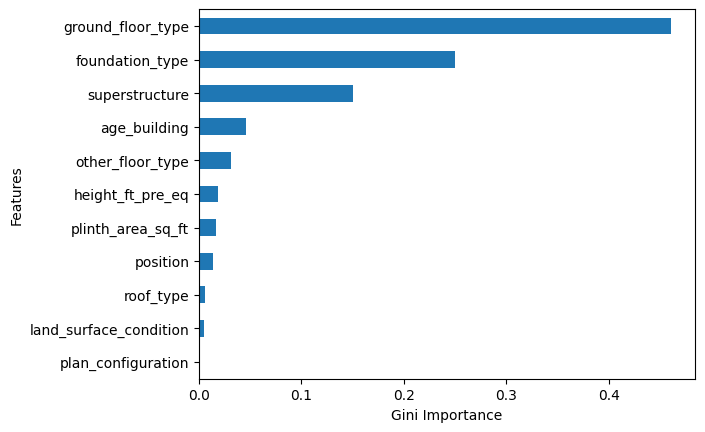

In [41]:
#Plot 'feat_imp'
feat_imp.plot(kind="barh", xlabel="Gini Importance", ylabel="Features")


First, it is important to note that none of the importance values are more than 1, only between 0 and 1, and the sum of all the values is equal to 1.

The Gini Importance for Ground floor type is around 0.45(45%). It means that this feature is responsible for about 45% increase in purity as the tree splits from the roots to the leaves.

Similarly, the feature "height of a building pre-earthquake" seems to be responsible for around 3-4% of the reduction in impurity throughout the tree.

For Decision trees, all feature importances are positive meaning I cannot conclude whether the feature exerts a downward or upward pressure on the model's predictions.

Decision trees are flexible and easy to understand and visualize but it is not straighforward to explain them as opposed to linear models.

In summary, when building models as a data scientist, it’s crucial to balance the importance of explainability, accuracy, and computational resources to building effective models.

# **Conclusion**

I have built a Decision Tree model and tuned hyperparameters, focusing on max depth. I have also interpreted my model's predictions using Gini Importance.

While building my model, I was able split my data into training(for training my model), validation(hyperparameter tuning) and test data(for final model evaluation)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 762094 entries, 120101000011 to 366709001281
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   age_building            762094 non-null  int64 
 1   plinth_area_sq_ft       762094 non-null  int64 
 2   height_ft_pre_eq        762094 non-null  int64 
 3   land_surface_condition  762094 non-null  object
 4   foundation_type         762094 non-null  object
 5   roof_type               762094 non-null  object
 6   ground_floor_type       762094 non-null  object
 7   other_floor_type        762094 non-null  object
 8   position                762094 non-null  object
 9   plan_configuration      762094 non-null  object
 10  superstructure          762094 non-null  object
 11  severe_damage           762094 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 75.6+ MB
